### Import Packages

In [2]:
import os 
import re 
from tqdm import tqdm

# import numpy as np 
# import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 

In [3]:
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

### Data Loading

In [4]:
train_datasets = datasets.MNIST('./data', True, transform=transforms.ToTensor(), download=True)
test_datasets = datasets.MNIST('./data', False, transform=transforms.ToTensor(), download=True)

In [5]:
train_datasets

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
image , label  = train_datasets[0]

In [7]:
image.shape

torch.Size([1, 28, 28])

In [8]:
image.shape

torch.Size([1, 28, 28])

In [9]:
image.squeeze().shape

torch.Size([28, 28])

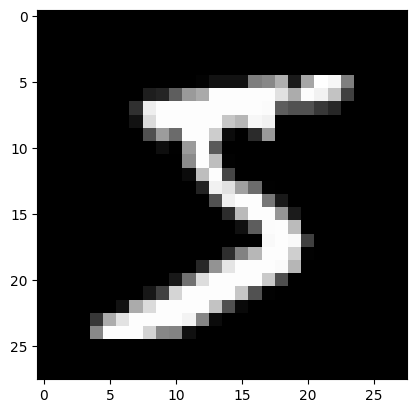

In [10]:
plt.imshow(image.squeeze(), cmap='gray')

In [11]:
import numpy as np

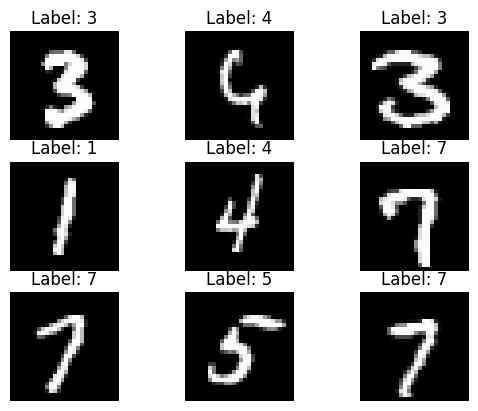

In [12]:
for i in range(1, 10):
    plt.subplot(3, 3, i)
    n = np.random.randint(0, 60000, 1)[0]
    image, label = train_datasets[n]
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')

In [13]:
train_dataloader = DataLoader(train_datasets, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_datasets, batch_size=128, shuffle=False)

In [14]:
image_batch, label_batch = next(iter(train_dataloader))

In [15]:
image_batch.shape

torch.Size([128, 1, 28, 28])

In [16]:
label_batch

tensor([0, 8, 3, 3, 2, 2, 8, 3, 0, 9, 1, 0, 4, 6, 9, 6, 4, 2, 7, 7, 6, 5, 3, 9,
        1, 6, 9, 0, 3, 7, 9, 6, 9, 5, 8, 4, 7, 1, 5, 1, 6, 3, 9, 4, 9, 8, 5, 2,
        1, 9, 5, 7, 9, 8, 5, 8, 8, 0, 6, 3, 7, 1, 7, 3, 0, 5, 9, 3, 9, 1, 5, 3,
        0, 2, 7, 7, 5, 0, 6, 7, 9, 7, 1, 1, 9, 9, 5, 0, 3, 3, 0, 2, 8, 0, 2, 7,
        7, 7, 3, 2, 3, 3, 2, 8, 3, 9, 7, 3, 8, 7, 4, 7, 0, 3, 6, 0, 8, 8, 6, 0,
        2, 1, 1, 2, 6, 8, 8, 6])

In [17]:
for images, labels in train_dataloader:
    print(images.shape, labels.shape)
    break

torch.Size([128, 1, 28, 28]) torch.Size([128])


In [18]:
labels

tensor([9, 7, 3, 9, 2, 4, 5, 9, 2, 1, 7, 6, 0, 9, 5, 2, 8, 6, 9, 2, 4, 9, 3, 9,
        5, 9, 0, 4, 2, 7, 3, 7, 8, 9, 7, 1, 5, 9, 9, 0, 9, 2, 4, 7, 6, 5, 3, 2,
        4, 5, 8, 6, 8, 8, 6, 3, 3, 9, 7, 5, 1, 1, 8, 0, 9, 8, 0, 6, 1, 1, 6, 4,
        0, 0, 8, 9, 0, 6, 7, 1, 9, 1, 8, 5, 3, 6, 0, 3, 1, 7, 5, 9, 5, 4, 4, 9,
        8, 5, 1, 3, 7, 1, 4, 6, 9, 3, 6, 1, 2, 8, 7, 2, 2, 8, 3, 2, 3, 8, 2, 4,
        0, 1, 1, 7, 5, 4, 5, 3])

### Model Preparation

In [19]:
## SImple Deep Neural 
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fcn  = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 128),
            nn.ReLU(inplace=True),

            nn.Linear(128, 64),
            nn.ReLU(inplace=True),

            nn.Linear(64, 10),
            nn.Softmax()
        )  # Fully Connected Network
    
    def forward(self, x):
        flatten_x = self.flatten(x)
        output = self.fcn(flatten_x)
        return output

model = MNISTClassifier()
model(images)[9]

/home/fm-pc-lt-278/miniconda3/envs/torch/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([0.0960, 0.1068, 0.1033, 0.0882, 0.1071, 0.0871, 0.1063, 0.1056, 0.1006,
        0.0988], grad_fn=<SelectBackward0>)

### Paramter and Traning Pipeline

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
model = MNISTClassifier() 
model = model.to(device=device)
# loss_fn
criteria = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.005) 
epochs = 100

In [22]:
def train_one_step(model, criteria, optimizer, images, labels):
    ## Forward Pass 
    model.train() ## model mode --> train / eval --> fast processing 
    optimizer.zero_grad()  # Graadient Zero Initialization

    outputs = model(images)
    loss = criteria(outputs, labels)  # Loss Calculation -- L

    ## Backward Pass
    loss.backward()  # Gradient Calculation --> dL / dW
    optimizer.step()  # weight Optimization --> w1 = w1 - lr * dL/dW

    return loss

def validate_one_step(model, criteria, images, labels):
    ## Forward Pass 
    model.eval() ## model mode --> train / eval --> fast processing 
    
    outputs = model(images)
    loss = criteria(outputs, labels)  # Loss Calculation -- L

    return loss

In [23]:
train_loss, validation_loss = [], []
for epoch in range(epochs):
    ## Training Loop 
    epoch_train_loss = 0
    for images, labels in tqdm(train_dataloader, desc=f"Training {epoch} of {epochs}"):
        images, labels = images.to(device), labels.to(device)
        loss = train_one_step(model, criteria, optimizer, images, labels)
        epoch_train_loss = epoch_train_loss + loss.item()
    
    epoch_train_loss /= len(train_dataloader)
    train_loss.append(epoch_train_loss)


    ## Validation Loop
    epoch_validation_loss = 0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        loss = validate_one_step(model, criteria, images, labels)
        epoch_validation_loss = epoch_validation_loss + loss.item()
    
    epoch_validation_loss /= len(test_dataloader)
    validation_loss.append(epoch_validation_loss)

    print("Training Loss: ", epoch_train_loss, "valiation Loss", epoch_validation_loss)



100%|██████████| 79/79 [00:00<00:00, 102.25it/s]


Training Loss:  1.7287283116566348 valiation Loss 1.6255440063114408


100%|██████████| 79/79 [00:00<00:00, 114.02it/s]


Training Loss:  1.5549910945424648 valiation Loss 1.5426584527462344


100%|██████████| 79/79 [00:00<00:00, 115.03it/s]


Training Loss:  1.5476160989895558 valiation Loss 1.540530022186569


100%|██████████| 79/79 [00:00<00:00, 116.59it/s]


Training Loss:  1.5538350742763039 valiation Loss 1.5364250140854074


100%|██████████| 79/79 [00:00<00:00, 108.84it/s]


Training Loss:  1.5645029033933366 valiation Loss 1.5338595456714872


100%|██████████| 79/79 [00:00<00:00, 114.45it/s]


Training Loss:  1.5605536635750648 valiation Loss 1.5542239011088503


100%|██████████| 79/79 [00:00<00:00, 114.16it/s]


Training Loss:  1.550201272913642 valiation Loss 1.5365186099764667


100%|██████████| 79/79 [00:00<00:00, 113.23it/s]


Training Loss:  1.5546135841402164 valiation Loss 1.5463184631323512


100%|██████████| 79/79 [00:00<00:00, 102.65it/s]


Training Loss:  1.5605864491798223 valiation Loss 1.5540713992299913


100%|██████████| 79/79 [00:00<00:00, 107.04it/s]


Training Loss:  1.5819707613255678 valiation Loss 1.6327212294445763


100%|██████████| 79/79 [00:00<00:00, 110.54it/s]


Training Loss:  1.5771980054342924 valiation Loss 1.5947153960602194


100%|██████████| 79/79 [00:00<00:00, 105.64it/s]


Training Loss:  1.5875534103877509 valiation Loss 1.6344672471662112


Training 12 of 100:  43%|████▎     | 204/469 [00:02<00:02, 93.79it/s]


KeyboardInterrupt: 

### Training and Plotting

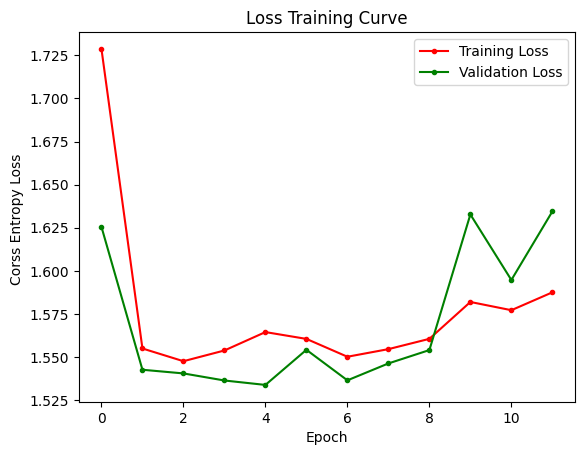

In [33]:
plt.plot(train_loss, 'r.-')
plt.plot(validation_loss, 'g.-')
plt.xlabel("Epoch")
plt.ylabel("Corss Entropy Loss ")
plt.title('Loss Training Curve')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()